# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
"""NIHCXR Clinical Drift Experiments Tutorial."""

from functools import partial

import numpy as np
from monai.transforms import Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device


device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender",
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        Resized(
            keys=("features",), spatial_size=(224, 224), allow_missing_keys=True,
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        Lambdad(("features",), func=lambda x: np.mean(x, axis=0)[np.newaxis, np.newaxis, :] if x.shape[0] != 1 else x[np.newaxis, :], allow_missing_keys=True),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 71428.79 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 97824.06 examples/s]

Filter (num_proc=6):  48%|████▊     | 53374/112120 [00:00<00:00, 101912.95 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 128874.93 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 141738.06 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 147026.14 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 114495.15 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 73094.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 101323.32 examples/s]

Filter (num_proc=6):  49%|████▉     | 55374/112120 [00:00<00:00, 110727.94 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143390.94 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 147499.62 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 118119.58 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.44 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 20.47 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.73 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.61 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.74 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.68 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.19 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.31 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.83 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.69 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.40 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.53 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.29 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.82 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.00 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.86 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.20 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.99 examples/s]

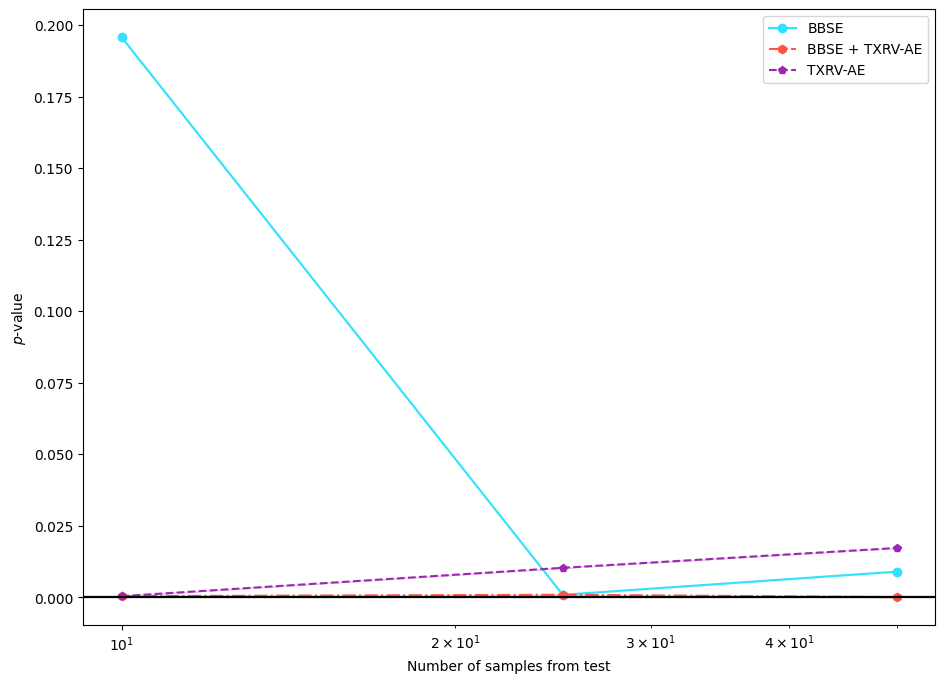

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.57 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.68 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.54 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.54 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.76 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.55 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.41 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.48 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.09 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.23 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.11 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.18 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.47 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.46 examples/s]

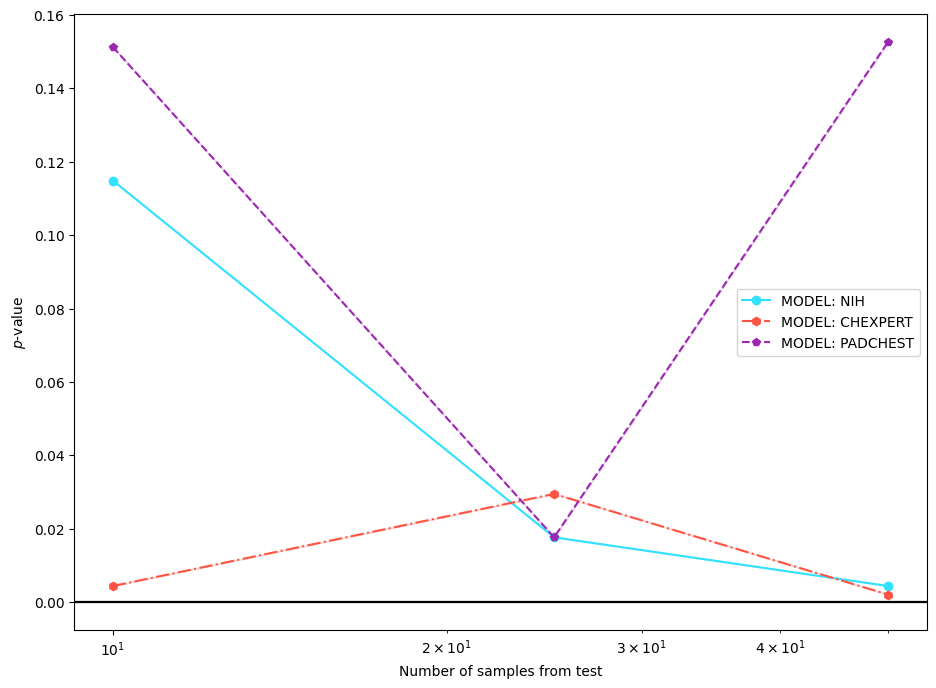

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device,
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59609.44 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 85212.85 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 99294.83 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 108029.34 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 113442.26 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 117288.95 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94122.84 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54894.26 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77018.46 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84677.12 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91025.02 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101156.07 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109772.61 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 85840.32 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.56 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.98 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.83 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.32 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.21 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.73 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59770.63 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 84604.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 98864.67 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 107872.27 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 112999.73 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 118820.42 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94175.88 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59843.87 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 86059.81 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 100076.54 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 108237.31 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 113233.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 121121.50 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 95413.42 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.56 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.45 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.31 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.54 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.49 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.02 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 60399.30 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 88625.12 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 101877.65 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 109317.89 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 113811.67 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 117280.78 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94752.98 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55988.25 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81116.67 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96625.18 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 105671.83 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110852.87 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 115956.52 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92103.54 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.92 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.00 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.87 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.20 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.06 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59446.99 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 84888.48 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 98122.62 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 106951.25 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 111598.53 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114734.10 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92627.43 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55090.50 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76462.16 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87666.14 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97320.73 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108740.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 122741.07 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 91027.43 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.51 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.68 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.55 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.32 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.88 examples/s]

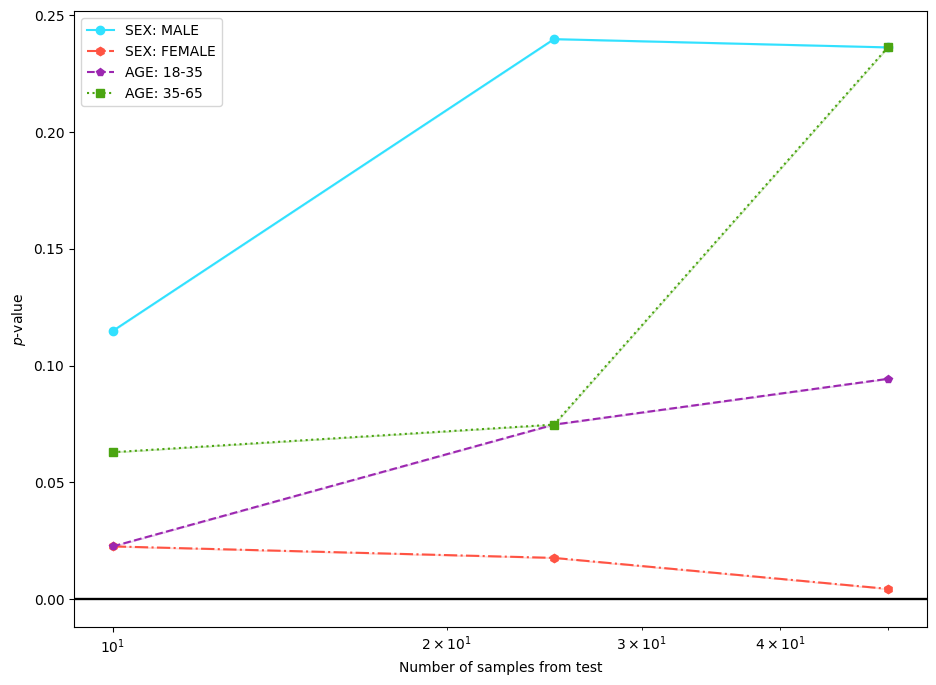

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}],
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}],
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice,
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.81 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.87 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.72 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.13 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.28 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.15 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.92 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.79 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.04 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.91 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.59 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.45 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.04 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.91 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.52 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.38 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.61 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.47 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.97 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.84 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.50 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.35 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.19 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.19 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.27 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.13 examples/s]

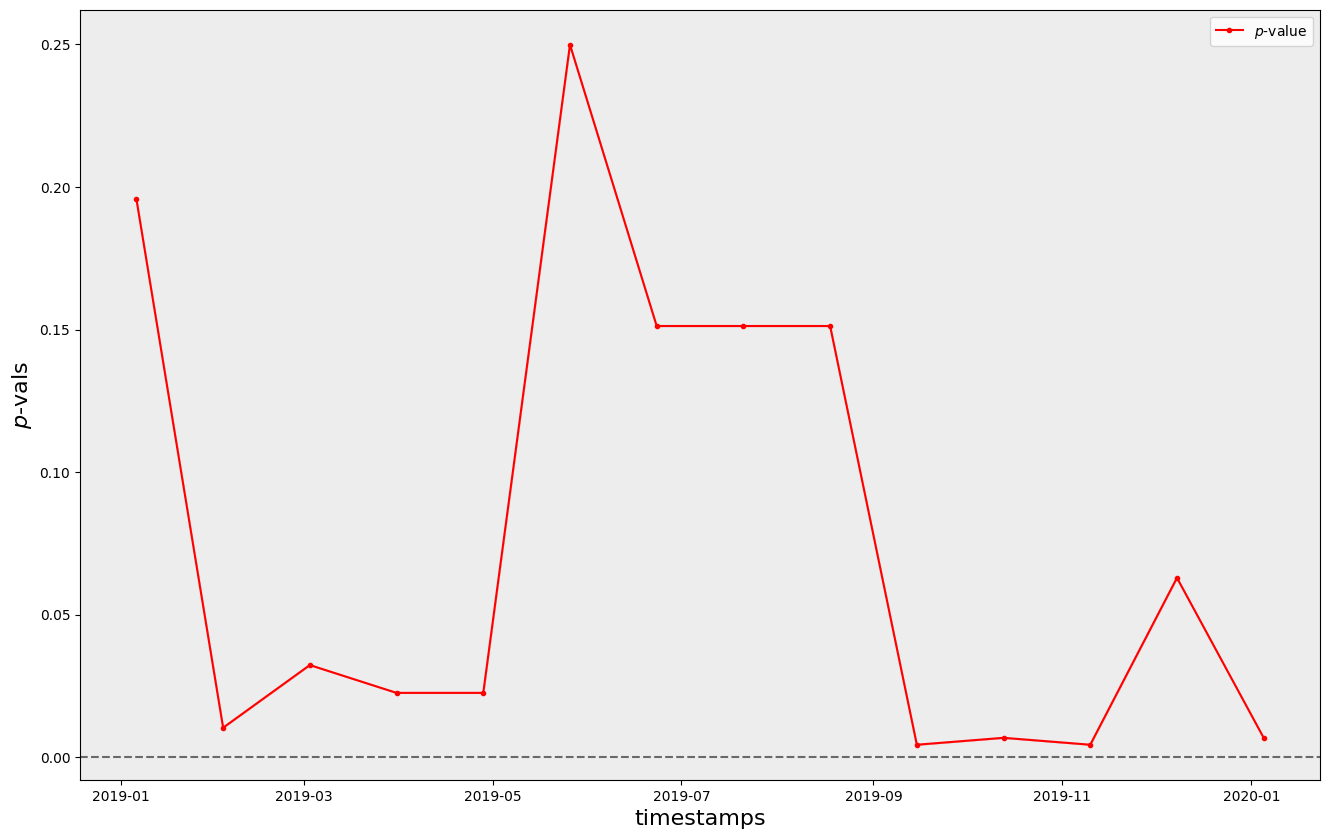

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="ks"),
    source_sample_size=50,
    target_sample_size=10,
    timestamp_column="timestamp",
    window_size="4W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)